# Mineria de Patrones - Online Retail

Notebook organizado en 4 partes (itemsets frecuentes, reglas + lift, closed/maximal y comparacion final) sobre el dataset Online Retail limpio.

Usaremos el dataset `Online Retail` (2010-2011). Si el archivo procesado no existe, se limpia automaticamente a partir de `data/raw/online_retail.csv` replicando la tuberia usada en `eda.ipynb` (sin cancelaciones, cantidades/precios positivos, productos frecuentes).

In [1]:
!pip install -q pandas numpy seaborn matplotlib mlxtend pyfim kagglehub

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from mlxtend.frequent_patterns import fpgrowth, association_rules, fpmax
from mlxtend.preprocessing import TransactionEncoder

sns.set_theme(style="whitegrid")
pd.options.display.float_format = "{:,.4f}".format

DATA_DIR = Path("data")
RAW_PATH = DATA_DIR / "raw" / "online_retail.csv"
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_online_retail.csv"
RESULTS_DIR = DATA_DIR / "processed"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Parametros para las preguntas
SUPPORT_GRID = [0.01, 0.02, 0.05]
BASE_SUPPORT = SUPPORT_GRID[0]  # 1%
MIN_CONF = 0.60
np.random.seed(42)


## Carga y preprocesamiento
Se reutiliza la funcion de limpieza de `eda.ipynb`: se eliminan cancelaciones, cantidades/precios no positivos, descripciones vacias, duplicados exactos y productos con frecuencia < 50. Si ya existe `data/processed/cleaned_online_retail.csv` se reutiliza para no recalcular.

In [3]:
def clip_iqr(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)


def clean_retail(df, min_item_freq=50):
    out = df.copy()
    out['InvoiceNo'] = out['InvoiceNo'].astype(str).str.strip()

    out = out[~out['InvoiceNo'].str.startswith('C')]
    out = out[(out['Quantity'] > 0) & (out['UnitPrice'] > 0)]

    out['Description'] = out['Description'].astype(str).str.strip()
    out = out[out['Description'] != ""]
    out = out.dropna(subset=['Description'])

    out['InvoiceDate'] = pd.to_datetime(out['InvoiceDate'])
    out['Country'] = out['Country'].astype(str).str.strip()

    out = out.drop_duplicates()

    counts = out['Description'].value_counts()
    keep_items = counts[counts >= min_item_freq].index
    out = out[out['Description'].isin(keep_items)]

    out['Quantity'] = clip_iqr(out['Quantity'])
    out['UnitPrice'] = clip_iqr(out['UnitPrice'])
    return out


def load_dataset():
    if PROCESSED_PATH.exists():
        df = pd.read_csv(PROCESSED_PATH)
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        print(f"Dataset limpio cargado desde {PROCESSED_PATH}.")
    else:
        if not RAW_PATH.exists():
            raise FileNotFoundError("Falta data/raw/online_retail.csv. Descarga o coloca el archivo para continuar.")
        df_raw = pd.read_csv(RAW_PATH)
        df = clean_retail(df_raw, min_item_freq=50)
        df.to_csv(PROCESSED_PATH, index=False)
        print(f"Dataset limpio generado y guardado en {PROCESSED_PATH}.")
    print(f"Filas: {len(df):,} | Facturas: {df['InvoiceNo'].nunique():,} | Productos: {df['Description'].nunique():,}")
    return df


df = load_dataset()


Dataset limpio cargado desde data/processed/cleaned_online_retail.csv.
Filas: 494,588 | Facturas: 19,748 | Productos: 2,190


## Preparacion de transacciones (one-hot)
Se agrupan los items por factura y se construye una matriz one-hot unica para todas las partes del analisis.

In [4]:
transactions = df.groupby('InvoiceNo')['Description'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
onehot = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Transacciones: {len(transactions):,} | Items unicos: {onehot.shape[1]}")
print(f"Densidad promedio one-hot: {onehot.values.mean():.4f}")


Transacciones: 19,748 | Items unicos: 2190
Densidad promedio one-hot: 0.0113


## Particion temporal (H1 vs H2)
Se separa 2011 en dos mitades para medir crecimientos de patrones (growth rate). Se reutiliza el mismo espacio de items (encoder unico).

In [5]:
cutoff = pd.Timestamp('2011-06-01')
part1 = df[df['InvoiceDate'] < cutoff]
part2 = df[df['InvoiceDate'] >= cutoff]

transactions1 = part1.groupby('InvoiceNo')['Description'].apply(list).tolist()
transactions2 = part2.groupby('InvoiceNo')['Description'].apply(list).tolist()

# Reusar el encoder ajustado con todas las transacciones
onehot_1 = pd.DataFrame(te.transform(transactions1), columns=te.columns_)
onehot_2 = pd.DataFrame(te.transform(transactions2), columns=te.columns_)

print(f"H1 transacciones: {len(transactions1):,} | H2 transacciones: {len(transactions2):,}")


H1 transacciones: 8,024 | H2 transacciones: 11,724


## Parte 1: Itemsets Frecuentes (5 puntos)
1. Mineria de itemsets frecuentes con minsup de 1%, 2% y 5%.
2. Conteo de itemsets frecuentes para cada minsup.
3. Explicacion de lo que ocurre al aumentar `minsup`.

In [6]:
def run_fpgrowth(df_oh, min_support):
    freq = fpgrowth(df_oh, min_support=min_support, use_colnames=True)
    freq = freq.sort_values(by='support', ascending=False).reset_index(drop=True)
    freq['length'] = freq['itemsets'].apply(len)
    return freq


freq_by_support = {}
summary_rows = []
for sup in SUPPORT_GRID:
    freq = run_fpgrowth(onehot, sup)
    freq_by_support[sup] = freq
    summary_rows.append({'minsup': sup, 'itemsets': len(freq)})

freq_summary = pd.DataFrame(summary_rows)
print("Itemsets frecuentes por minsup:")
print(freq_summary)

# Vistazo a los 5 itemsets con mayor soporte al 1%
freq_by_support[BASE_SUPPORT].head()


Itemsets frecuentes por minsup:
   minsup  itemsets
0  0.0100      1960
1  0.0200       389
2  0.0500        34


,support,itemsets,length
0,0.1142,(WHITE HANGING HEART T-LIGHT HOLDER),1
1,0.1058,(JUMBO BAG RED RETROSPOT),1
2,0.1007,(REGENCY CAKESTAND 3 TIER),1
3,0.0853,(PARTY BUNTING),1
4,0.0792,(LUNCH BAG RED RETROSPOT),1


Con minsup=1% se obtienen mas combinaciones (se capturan hasta co-ocurrencias poco frecuentes). Al subir a 2% y 5% solo sobreviven las combinaciones repetidas en muchas facturas, reduciendo el espacio de busqueda y dejando patrones mas robustos comercialmente.

## Parte 2: Reglas de Asociacion y Lift (5 puntos)
1. Reglas con minconf = 60% sobre los itemsets de minsup=1%.
2. Calculo de lift para cada regla.
3. Top 3 reglas por lift y su lectura comercial.

In [7]:
freq_base = freq_by_support[BASE_SUPPORT]
rules = association_rules(freq_base, metric='confidence', min_threshold=MIN_CONF)
rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)

print(f"Reglas generadas: {len(rules)}")
top3_lift = rules[['antecedents','consequents','support','confidence','lift']].head(3)
display(top3_lift)


Reglas generadas: 559


,antecedents,consequents,support,confidence,lift
0,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.0103,0.8565,78.6742
1,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.0103,0.9442,78.6742
2,(HERB MARKER ROSEMARY),"(HERB MARKER PARSLEY, HERB MARKER THYME)",0.0103,0.8458,78.4203


Las reglas con mayor lift conectan los marcadores de hierbas (`HERB MARKER THYME`, `PARSLEY`, `ROSEMARY`): cuando un cliente compra uno, casi siempre lleva el set completo (confianza >84% y lift >78). Comercialmente es un paquete natural para promociones cruzadas o displays conjuntos porque la probabilidad de compra conjunta es decenas de veces mayor que al azar.

## Skypatterns (skyline) de reglas y graficas
Skypatterns = reglas no dominadas simultaneamente en **soporte**, **confianza** y **lift** (ninguna otra regla es mejor o igual en los tres criterios). Esto resalta patrones con buen equilibrio de frecuencia e intensidad. Se visualiza el skyline sobre el mapa soporte–confianza coloreado por lift.

In [8]:
def skyline_rules(rules_df, metrics=("support", "confidence", "lift")):
    vals = rules_df[list(metrics)].to_numpy()
    keep = []
    n = len(rules_df)
    for i in range(n):
        dominated = False
        for j in range(n):
            if i == j:
                continue
            if all(vals[j, k] >= vals[i, k] for k in range(len(metrics))) and any(vals[j, k] > vals[i, k] for k in range(len(metrics))):
                dominated = True
                break
        if not dominated:
            keep.append(i)
    return rules_df.iloc[keep].sort_values(by=list(metrics), ascending=False)

sky_rules = skyline_rules(rules)
print(f"Skypatterns (reglas skyline): {len(sky_rules)} de {len(rules)} reglas totales")
display(sky_rules[['antecedents','consequents','support','confidence','lift']].head(10))


Skypatterns (reglas skyline): 19 de 559 reglas totales


,antecedents,consequents,support,confidence,lift
546,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.0418,0.6773,6.4031
303,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.0388,0.7572,14.0398
228,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.0320,0.8261,16.1053
182,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.0274,0.9047,17.6364
166,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.0274,0.7072,18.2081
165,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.0274,0.7053,18.2081
107,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.0196,0.7578,27.8165
106,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.0196,0.7212,27.8165
89,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.0177,0.8178,30.6434
62,(REGENCY TEA PLATE GREEN),(REGENCY TEA PLATE ROSES),0.0162,0.8373,37.1560


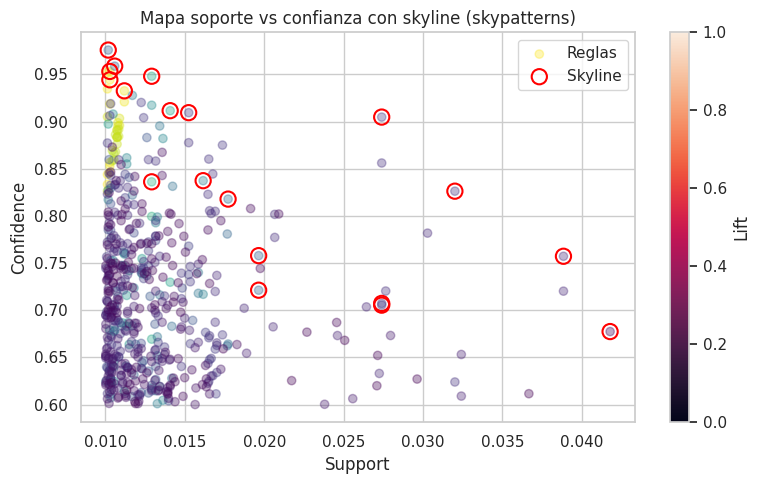

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='viridis', alpha=0.35, label='Reglas')
plt.scatter(sky_rules['support'], sky_rules['confidence'], edgecolor='red', facecolor='none', s=120, linewidths=1.5, label='Skyline')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Mapa soporte vs confianza con skyline (skypatterns)')
plt.legend()
plt.tight_layout()
plt.show()


Las reglas skyline combinan soporte razonable con confianza y lift altos sin ser dominadas por otras. Son candidatas directas para campañas: alto lift implica co-compra fuerte y soporte decente asegura impacto en ventas.

## Patrones emergentes (growth rate H2 vs H1)
Se calcula el growth rate = soporte(H2) / soporte(H1) con minsup=1% para identificar itemsets que crecen o aparecen en la segunda mitad del año (JEP si soporte en H1=0). Incluye graficos de los incrementos y JEPs mas soportados.

In [10]:
# Itemsets frecuentes por particion
freq_h1 = fpgrowth(onehot_1, min_support=BASE_SUPPORT, use_colnames=True)
freq_h2 = fpgrowth(onehot_2, min_support=BASE_SUPPORT, use_colnames=True)

merged = pd.merge(freq_h1, freq_h2, on='itemsets', how='outer', suffixes=('_1', '_2')).fillna(0)
merged['growth_rate'] = np.where(
    merged['support_1'] == 0,
    np.inf,
    merged['support_2'] / merged['support_1']
)

jep = merged[merged['growth_rate'] == np.inf].sort_values(by='support_2', ascending=False)
inc = merged[(merged['growth_rate'] > 1) & (merged['growth_rate'] != np.inf)].sort_values(by='growth_rate', ascending=False)
stable = merged[(merged['growth_rate'] >= 0.8) & (merged['growth_rate'] <= 1.2)].sort_values(by='support_2', ascending=False)
dec = merged[(merged['growth_rate'] < 0.8) & (merged['support_2'] > 0)].sort_values(by='growth_rate')

print(f"Itemsets comparados: {len(merged)} | JEPs: {len(jep)} | Incrementan: {len(inc)} | Estables: {len(stable)} | Decrecen: {len(dec)}")
print("Top 5 incrementos (sin inf):")
display(inc[['itemsets','support_1','support_2','growth_rate']].head())
print("Top 5 JEP (solo en H2):")
display(jep[['itemsets','support_1','support_2']].head())


Itemsets comparados: 4135 | JEPs: 1966 | Incrementan: 482 | Estables: 617 | Decrecen: 300
Top 5 incrementos (sin inf):


,itemsets,support_1,support_2,growth_rate
2505,(RABBIT NIGHT LIGHT),0.0111,0.0772,6.9594
2498,(JUMBO BAG VINTAGE LEAF),0.0138,0.0655,4.7354
2499,(JUMBO BAG PEARS),0.0103,0.0437,4.2219
3031,(60 CAKE CASES VINTAGE CHRISTMAS),0.0112,0.0450,4.0152
2646,(HAND WARMER OWL DESIGN),0.0123,0.0473,3.8368


Top 5 JEP (solo en H2):


,itemsets,support_1,support_2
601,(SET OF 3 REGENCY CAKE TINS),0.0000,0.0745
727,(GARDENERS KNEELING PAD KEEP CALM),0.0000,0.0723
954,(POPCORN HOLDER),0.0000,0.0685
811,(HOT WATER BOTTLE KEEP CALM),0.0000,0.0667
920,(JUMBO BAG 50'S CHRISTMAS),0.0000,0.0611


/tmp/ipykernel_2561/892384481.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


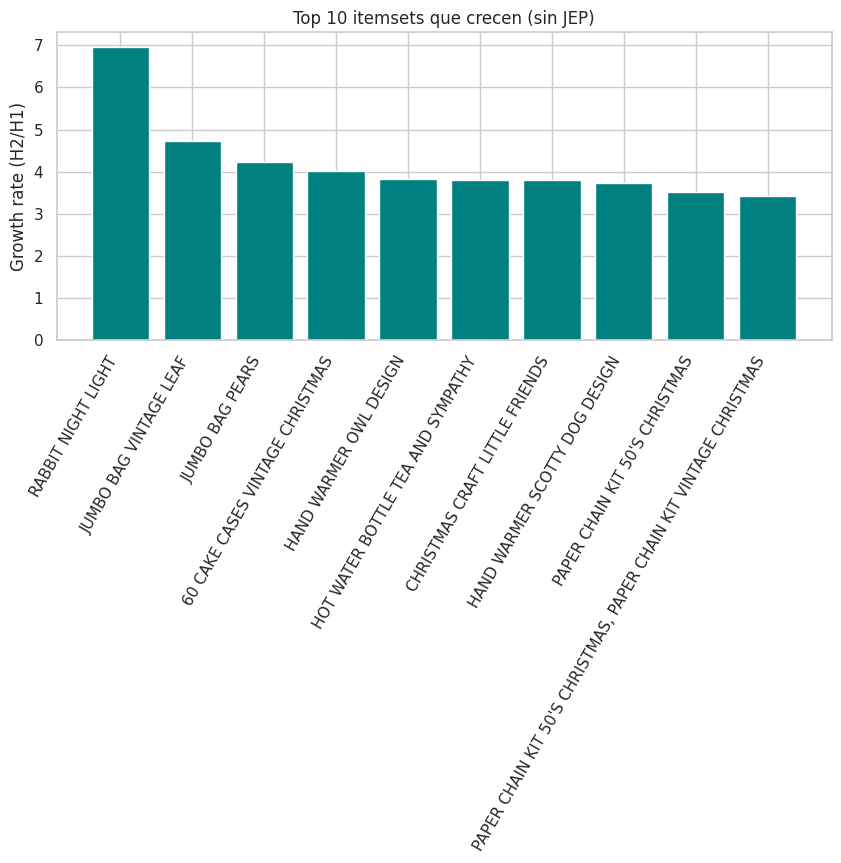

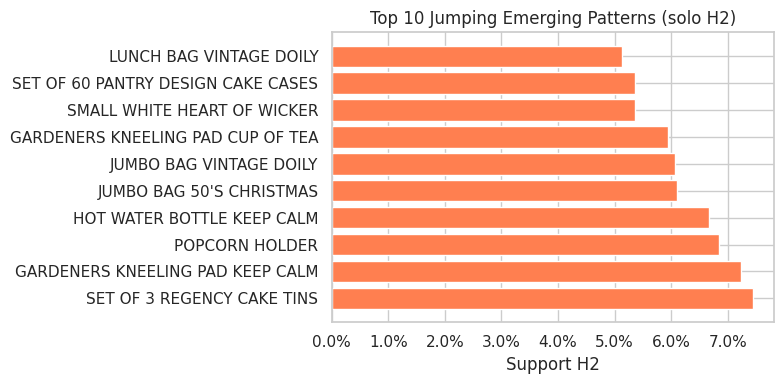

In [11]:
# Graficas
from matplotlib.ticker import PercentFormatter

def iset_to_str(s):
    try:
        return ', '.join(sorted(s))
    except Exception:
        return str(s)

plot_inc = inc.head(10).copy()
plot_inc['item'] = plot_inc['itemsets'].apply(iset_to_str)
plt.figure(figsize=(10,4))
plt.bar(plot_inc['item'], plot_inc['growth_rate'], color='teal')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Growth rate (H2/H1)')
plt.title('Top 10 itemsets que crecen (sin JEP)')
plt.tight_layout()
plt.show()

plot_jep = jep.head(10).copy()
plot_jep['item'] = plot_jep['itemsets'].apply(iset_to_str)
plt.figure(figsize=(8,4))
plt.barh(plot_jep['item'], plot_jep['support_2'], color='coral')
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlabel('Support H2')
plt.title('Top 10 Jumping Emerging Patterns (solo H2)')
plt.tight_layout()
plt.show()


Los itemsets con mayor growth rate evidencian cambios estacionales: crecen en H2 respecto a H1. Los JEPs solo aparecen en H2 (growth infinito), util para campañas específicas de temporada. Graficas permiten priorizar por impacto (support H2) y velocidad de crecimiento (growth rate).

### Filtrar patrones emergentes no navideños (NLP ligero mejorado)
Se normalizan las descripciones (minusculas, sin acentos) y se filtran itemsets con terminos/phrases navideñas (p.ej., christmas, xmas, noel, santa, tree, bauble, fairy lights, gingerbread). Esto remueve estacionalidad fuerte y deja otros patrones emergentes.

Patrones incrementales no navideños: 10 (de 482)
JEP no navideños: 10 (de 1966)


/tmp/ipykernel_2561/2093435018.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


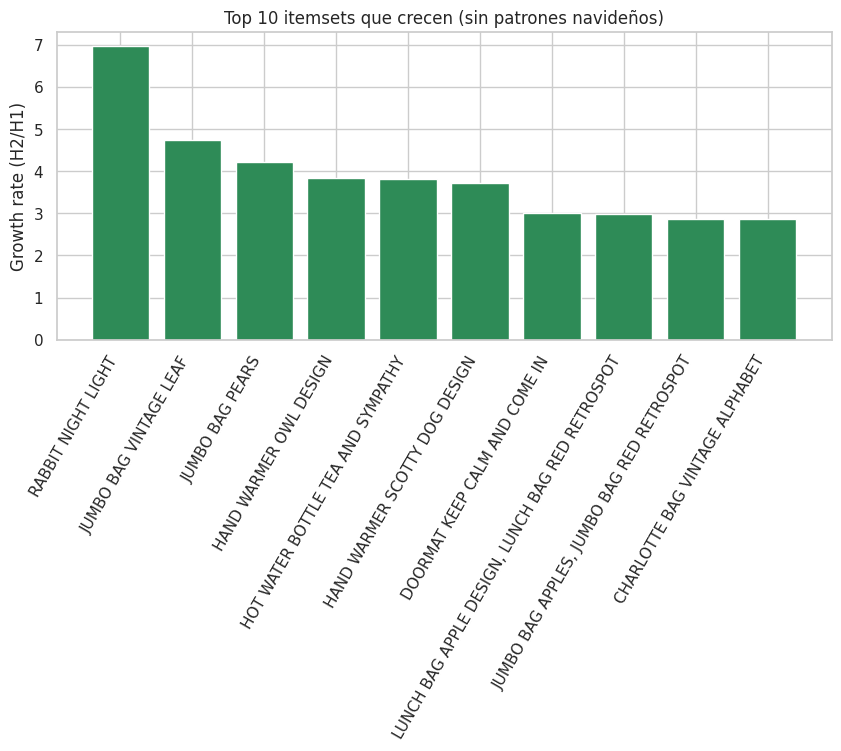

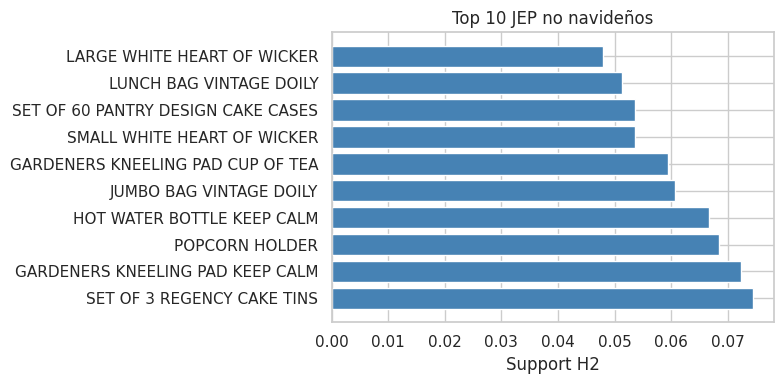

In [12]:
import re, unicodedata

navidad_patterns = [
    r"\bchristmas\b", r"\bxmas\b", r"\bx-mas\b", r"\bnavidad\b", r"\bnoel\b",
    r"\bsanta\b", r"\breindeer\b", r"\bsnow\b", r"\btinsel\b", r"\bbaubles?\b",
    r"\bfairy\s+lights\b", r"\bchristmas\s+tree\b", r"\bgingerbread\b", r"\badvent\b", r"\bholly\b"
]
regexes = [re.compile(pat) for pat in navidad_patterns]

def normalize_text(txt):
    return unicodedata.normalize("NFKD", txt).encode("ascii", "ignore").decode("ascii").lower()

def is_navideno(itemset):
    txt = normalize_text(' '.join(itemset))
    return any(r.search(txt) for r in regexes)

merged['es_navideno'] = merged['itemsets'].apply(is_navideno)

inc_nonxmas = inc[~inc['itemsets'].apply(is_navideno)].head(10).copy()
jep_nonxmas = jep[~jep['itemsets'].apply(is_navideno)].head(10).copy()

print(f"Patrones incrementales no navideños: {len(inc_nonxmas)} (de {len(inc)})")
print(f"JEP no navideños: {len(jep_nonxmas)} (de {len(jep)})")

inc_nonxmas['item'] = inc_nonxmas['itemsets'].apply(lambda s: ', '.join(sorted(s)))
jep_nonxmas['item'] = jep_nonxmas['itemsets'].apply(lambda s: ', '.join(sorted(s)))

plt.figure(figsize=(10,4))
plt.bar(inc_nonxmas['item'], inc_nonxmas['growth_rate'], color='seagreen')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Growth rate (H2/H1)')
plt.title('Top 10 itemsets que crecen (sin patrones navideños)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.barh(jep_nonxmas['item'], jep_nonxmas['support_2'], color='steelblue')
plt.xlabel('Support H2')
plt.title('Top 10 JEP no navideños')
plt.tight_layout()
plt.show()


Los filtros NLP (regex + normalizacion) quitan terminos navideños para exponer otros patrones emergentes. Ajusta la lista de keywords si deseas excluir/admitir otros terminos estacionales o locales.

## Parte 3: Closed Itemsets y Maximal Itemsets (5 puntos)
1. Obtencion de closed y maximal itemsets (minsup=1%).
2. Muestra de 5 ejemplos de cada grupo.
3. Explicacion de por que los maximal reducen el espacio de busqueda.

In [13]:
def get_closed_itemsets(freq_df):
    freq_df = freq_df.sort_values('support', ascending=False).reset_index(drop=True)
    itemsets = freq_df['itemsets'].tolist()
    supports = freq_df['support'].tolist()
    closed_mask = []
    for i, (iset, supp) in enumerate(zip(itemsets, supports)):
        closed = True
        for j, (other, supp_other) in enumerate(zip(itemsets, supports)):
            if i == j:
                continue
            if iset < other and supp == supp_other:
                closed = False
                break
        closed_mask.append(closed)
    return freq_df.loc[closed_mask].reset_index(drop=True)

closed_df = get_closed_itemsets(freq_base)
maximal_df = fpmax(onehot, min_support=BASE_SUPPORT, use_colnames=True)
maximal_df = maximal_df.sort_values(by='support', ascending=False).reset_index(drop=True)

print(f"Closed itemsets: {len(closed_df)} | Maximal itemsets: {len(maximal_df)} (minsup={BASE_SUPPORT*100:.0f}%)")
print("Top 5 closed itemsets:")
display(closed_df[['itemsets','support']].head())
print("Top 5 maximal itemsets:")
display(maximal_df[['itemsets','support']].head())


Closed itemsets: 1960 | Maximal itemsets: 1400 (minsup=1%)
Top 5 closed itemsets:


,itemsets,support
0,(WHITE HANGING HEART T-LIGHT HOLDER),0.1142
1,(JUMBO BAG RED RETROSPOT),0.1058
2,(REGENCY CAKESTAND 3 TIER),0.1007
3,(PARTY BUNTING),0.0853
4,(LUNCH BAG RED RETROSPOT),0.0792


Top 5 maximal itemsets:


,itemsets,support
0,(REX CASH+CARRY JUMBO SHOPPER),0.0441
1,(DOORMAT KEEP CALM AND COME IN),0.0369
2,(ANTIQUE SILVER T-LIGHT GLASS),0.0349
3,(GUMBALL COAT RACK),0.0345
4,(CHILLI LIGHTS),0.0335


Los maximal itemsets son aquellos sin supersets frecuentes; al eliminar todos los subconjuntos redundantes, condensan la misma informacion combinatoria en menos filas, reduciendo el espacio de busqueda (y memoria) sin perder los grupos mas grandes que ocurren juntos. Los closed preservan el soporte exacto de sus subconjuntos, por lo que mantienen mas detalle que los maximal.

## Parte 4: Comparacion y Analisis Final (5 puntos)
1. Comparacion entre itemsets frecuentes, closed y maximal.
2. Discusion de cual es mas util para un analista de negocio.

In [14]:
comparison = pd.DataFrame({
    'tipo': ['Frequent (>=1%)', 'Closed (>=1%)', 'Maximal (>=1%)'],
    'itemsets': [len(freq_base), len(closed_df), len(maximal_df)],
    'nota': [
        'Incluye todos los subconjuntos frecuentes',
        'Elimina subconjuntos con mismo soporte',
        'Solo conserva los mayores sin supersets frecuentes'
    ]
})
display(comparison)


,tipo,itemsets,nota
0,Frequent (>=1%),1960,Incluye todos los subconjuntos frecuentes
1,Closed (>=1%),1960,Elimina subconjuntos con mismo soporte
2,Maximal (>=1%),1400,Solo conserva los mayores sin supersets frecue...


Para un analista de negocio, los **closed itemsets** son un buen punto medio: eliminan redundancia pero mantienen soportes exactos para inferir tamanos reales de co-compra. Los **maximal** son utiles para resumir y priorizar (p.ej., armar bundles o planogramas rapidos), mientras que los frecuentes completos sirven para analisis detallados o para entrenar modelos, aunque generan un espacio de patrones mucho mas grande.